# Prerequisite

In [1]:
# Import
from PIL import Image, ImageFilter, ImageOps
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Pre-Processing (Crop, Gray Scale)

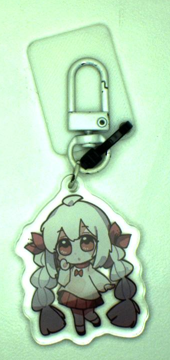

In [2]:
# Load image
filename = 'Lab 2 assets/Single.jpg'

with Image.open(filename) as img:
    img.load()

# Cropping
# 600, 120, 940, 840 for Single // 200, 120, 1060, 740 for G1_all
img = img.crop((600, 120, 940, 840))  # (left, top, right, bottom)

# Resize
img = img.resize((img.width // 2, img.height // 2))

# Gray scale
# img = img.convert('L')

display(img)

# Simple Segmentation

In [3]:
# Dialation and Erosion

def erosion(cycles, image):
    for i in range(cycles):
        image = image.filter(ImageFilter.MinFilter(3))
    return image

def dialation(cycles, image):
    for i in range(cycles):
        image = image.filter(ImageFilter.MaxFilter(3))
    return image

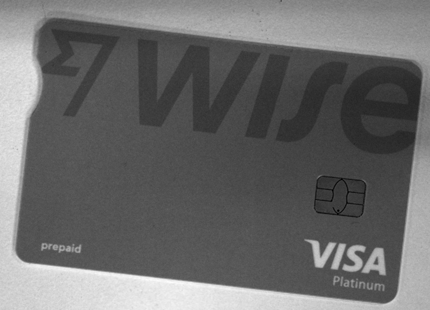

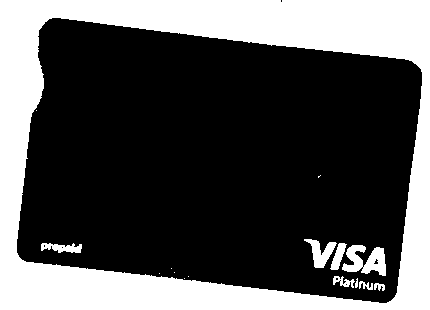

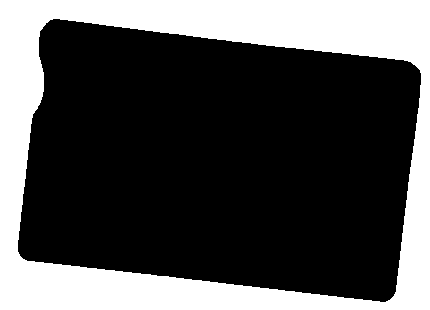

In [4]:
# Thresholding
threshold = 96

# Test intensity of 3 colours
red, green, blue = img.split()
display(red)  # Good with high contrast, but Inverted?
# display(green)  # Mix result
# display(blue)  # Bad

img_threshold = red.point(lambda p: p > threshold and 255)  # change colour channel if needed
display(img_threshold)

# ---------------------------------------------------------------

# Opening 
image_threshold = erosion(6, img_threshold)
image_threshold = dialation(6, image_threshold)

# Remove small noise using dialation
image_threshold = image_threshold.filter(ImageFilter.MaxFilter(3))

display(image_threshold)


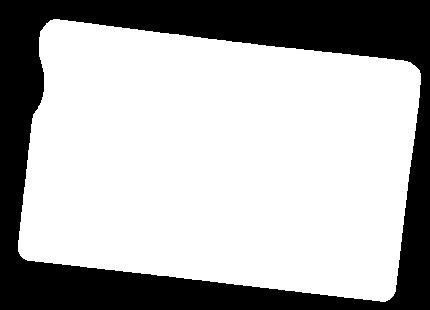

In [5]:
# Invert image for better visualization of object
image_threshold = ImageOps.invert(image_threshold)
display(image_threshold)

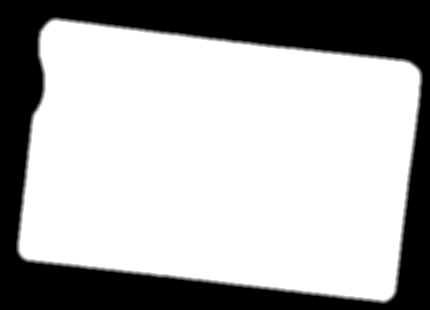

In [6]:
# Convert to gray scale and blur the mask
img_mask = image_threshold.convert('L')
img_mask = img_mask.filter(ImageFilter.BoxBlur(2))
display(img_mask)

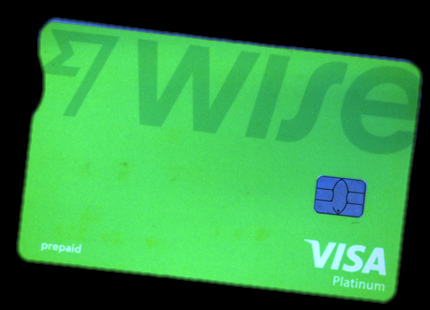

In [7]:
# Extract object
blank = img.point(lambda _: 0)
object_segmented = Image.composite(img, blank, img_mask)
display(object_segmented)

# K Mean Clustering

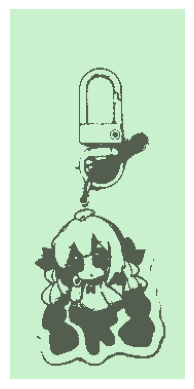

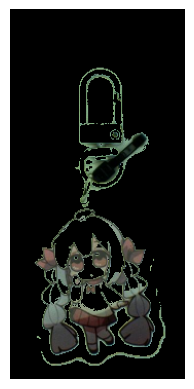

In [39]:
# K Mean Clustering
image_cv2 = cv2.imread('Lab 2 assets/Single.jpg')
image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

# Crop and resize
x_start, y_start, x_end, y_end = 600, 120, 940, 840
crop_image_cv2 = image_cv2[y_start:y_end, x_start:x_end]

scale_percent = 50
width = int(crop_image_cv2.shape[1] * scale_percent / 100)
height = int(crop_image_cv2.shape[0] * scale_percent / 100)
dim = (width, height)
resized_image = cv2.resize(crop_image_cv2, dim, interpolation=cv2.INTER_AREA)

image_cv2 = resized_image

# Gaussian Blur
# image_cv2 = cv2.GaussianBlur(image_cv2, (5, 5), 0)

pixel_values = image_cv2.reshape((-1, 3))  # 2D array

# Normalizing
pixel_values = pixel_values / 255.0

# K Mean Clustering
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(pixel_values)
segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]

# Reshape back to image
segmented_image = segmented_pixels.reshape(image_cv2.shape)
segmented_image = (segmented_image * 255).astype('uint8')

# Masking
object_cluster = 1
mask = (kmeans.labels_ == object_cluster)
mask = mask.reshape(image_cv2.shape[0], image_cv2.shape[1])

# Extract object
object_segmented = np.zeros_like(image_cv2)
object_segmented[mask] = image_cv2[mask]

# Display
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

plt.imshow(object_segmented)
plt.axis('off')
plt.show()

# Graph-Cut

# Level set